In [ ]:
def bet_positive_max(runners, bet_chunk):
    """bet max given prob>scale"""

    diffs = [(r['probability'] - r['odds_scale'], r) for r in runners]
    diffs.sort(key=itemgetter(0), reverse=True)

    ##############################################################################################
    # -1% roi 42% wr 100% races
    ##############################################################################################
#     num_bets = math.ceil(len(runners) * 0.125)


    ##############################################################################################
    # -2% roi 29% wr 100% races
    ##############################################################################################
    num_bets = 1


    ##############################################################################################
    # 10% roi 35% wr 33% races
    ##############################################################################################
#     num_bets = 1
#     if len(runners) > 8:
#         return [], 0

    
    ##############################################################################################
    # -3% roi 31% wr 77% races
    ##############################################################################################
#     num_bets = 1
#     if len(runners) > 12:
#         return [], 0

    
    ##############################################################################################
    # 0% roi 53% wr 33% races
    ##############################################################################################
#     num_bets = 2
#     if len(runners) > 8:
#         return [], 0

    total_probs = sum(d[1]['probability'] for d in diffs[:num_bets])
    for d, r in diffs[:num_bets]:
        r['bet'] = bet_chunk * r['probability'] / total_probs

    runners = [d[1] for d in diffs]
    return runners, num_bets


dfo = dfo.sample(frac=1).reset_index(drop=True)
print('Dataframe shuffled!')

book = process_strategy(dfo, bet_positive_max)

In [1]:
from sqlalchemy import create_engine
from operator import itemgetter
import json
import math

import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
engine = create_engine('sqlite:///tab.db')
conn = engine.connect()

dfo = pd.read_sql_table('race', conn)
print('{} races loaded!'.format(len(dfo)))

9587 races loaded!


In [3]:
category = 'G'
dfo = dfo.loc[dfo['race_type'].isin([category])]
print('{} {} races!'.format(len(dfo), category))

3931 G races!


In [4]:
dfo['results'] = dfo['results_data'].map(json.loads)
dfo['runners'] = dfo['runners_data'].map(json.loads)
dfo.describe()

,id,race_number,race_distance,num_runners
count,3931.000000,3931.000000,3931.000000,3931.000000
mean,5364.390995,6.397100,435.069448,7.635207
std,2986.357483,3.282893,81.886044,0.779000
min,1.000000,1.000000,0.000000,4.000000
25%,3084.500000,4.000000,390.000000,8.000000
50%,5481.000000,6.000000,431.000000,8.000000
75%,8006.500000,9.000000,515.000000,8.000000
max,10259.000000,12.000000,732.000000,10.000000


In [5]:
# bet size
balance = 1000
bet_chunk = balance * 0.01

In [6]:
def process_strategy(df, strategy):
    """run strategy, must pass runners returned back into results (it might be modified)"""
    book = []
    for _, race in df.iterrows():
#         print(race['num_runners'])
        runners = race['runners']
        
        # drop scratched
        runners = [r for r in runners if r['odds_win']]
        if not runners:
            continue
    
        # default 0 bets
        for runner in runners:
            runner['bet'] = 0
        
        runners, num_bets = strategy(runners, bet_chunk)
        if num_bets:
            bet_results(book, runners, race['num_runners'], bet_chunk, num_bets, race['race_type'])
    return book

In [7]:
def bet_results(book, runners, num_runners, bet_chunk, num_bets, race_type):
    """get results from bets"""
    win_diff = 0
    max_diff = 0
    prob2scales = []
    outcome = {
        'success': 0,
        'profit': -bet_chunk,
        'num_bets': num_bets,
        'num_runners': num_runners,
    }
    for i, runner in enumerate(runners):
        diff = abs(runner['odds_scale'] - runner['probability'])
        max_diff = max(max_diff, diff)
        if runner['bet']:
            prob2scales.append(runner['probability'] / runner['odds_scale'])
        if int(runner['finishingPosition']) == 1:
            win_diff = diff
            if runner['bet'] > 0:
                # odds = runner['parimutuel']['returnWin'] if runner['parimutuel']['returnWin'] else runner['odds_win']
                odds = runner['odds_win']
                profit = runner['bet'] * odds - bet_chunk
                outcome = {
                    'success': 1,
                    'profit': profit,
                    'num_bets': num_bets,
                    'num_runners': num_runners,
                }
            break

    outcome['max_diff'] = max_diff
    outcome['win_diff'] = win_diff
    outcome['prob2scale'] = min(prob2scales)
    outcome['bet_chunk'] = bet_chunk
    outcome['race_type'] = race_type
    outcome['runners'] = runners
    book.append(outcome)

In [846]:
def bet_positive_dutch(runners, bet_chunk):
    """dutch betting on probability"""

    # sort runners from favourite to underdog
    runners.sort(key=lambda r: r['probability'] / r['odds_scale'], reverse=True)
    
    # start betting on all and cut off worse runner till positive outcome
    for num_bets in range(len(runners), 0, -1):

        # reset bets
        for runner in runners:
            runner['bet'] = 0

        # recreate smaller pool
        pool = runners[:num_bets]
        # print('pool is {} from {} bets'.format(len(pool), num_bets))

        # all prediction values
        total_preds = sum([r['prediction'] for r in pool])

        # dutch for all in pool
        profits = []
        prob2scales = []
        for runner in pool:

            # scale bet according to prediction
            runner['bet'] = bet_chunk * runner['prediction'] / total_preds
            
            # need to check all as we scale to probs and not odds
            profits.append(runner['bet'] * runner['odds_win'] - bet_chunk)
            prob2scales.append(runner['probability'] / runner['odds_scale'])
            

        ###################################################################################        
        num_bets_flag = False
        min_bets = 1
        max_bets = 99
        if min_bets <= num_bets <= max_bets:
            num_bets_flag = True
        else:
            raise Exception('wtf')
            
        
        ###################################################################################        
        # MIN PROFIT
        ###################################################################################        
        min_profit_flag = False
        min_profit = min(profits)
        # 6.8  18  1691
        #if min_profit > bet_chunk * 0:
        # 7.7  17  1679
        #if min_profit > bet_chunk * 0.5:
        # 10.7  15  1655
        if min_profit > bet_chunk * 1:
        # 10.7  14  1645
        #if min_profit > bet_chunk * 1.5:
        # 10.6  13  1598
        #if min_profit > bet_chunk * 2:
        # 11.4  12  1485
        #if min_profit > bet_chunk * 2.5:
            min_profit_flag = True


        ###################################################################################
        # MIN PROB 2 SCALE
        ###################################################################################
        min_probs2scale_flag = False
        min_probs2scale = min(prob2scales)
        # 8.4  10  1475
        #if min_probs2scale >= 1.105:
        # 8.7  10  1415
        #if min_probs2scale >= 1.1070:
        # 9.2  15  1676
        #if min_probs2scale >= 1.1075:
        # 10.7  15  1655
        if min_probs2scale >= 1.1080:
        # 9.4  15  1639
        #if min_probs2scale >= 1.1085:
        # 9.4  10  1360
        #if min_probs2scale >= 1.1090:
            min_probs2scale_flag = True

            
        if min_profit_flag and num_bets_flag and min_probs2scale_flag: 
            #print('breaking: {} {} {} {}'.format(min_profit_flag, avg_profit_flag, num_bets_flag, min_probs2scale_flag))
            break
    else:
#         print('no profit determined')
        return [], 0

    # put bets from pool into runners
    for p in pool:
        for r in runners:
            if r['runnerNumber'] == p['runnerNumber']:
                r['bet'] = p['bet']
                break

    return runners, num_bets


dfo = dfo.sample(frac=1).reset_index(drop=True)
print('Dataframe shuffled!')

book = process_strategy(dfo, bet_positive_dutch)

Dataframe shuffled!


In [847]:
df = pd.DataFrame(book)
df.tail(1)

,bet_chunk,max_diff,num_bets,num_runners,prob2scale,profit,race_type,runners,success,win_diff
1639,10.0,0.021671,1,8.0,1.122007,-10.0,G,"[{'runnerName': 'MEEHAN BARNEY', 'runnerNumber...",0,0.008766


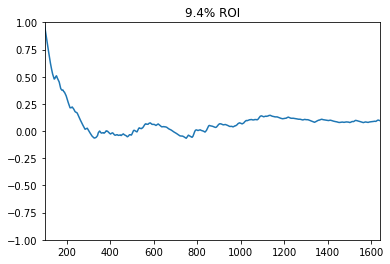

In [848]:
# ROI
roi = df.profit.cumsum() / df.bet_chunk.cumsum()
roi_title = '{:.1f}% ROI'.format(roi.iloc[-1] * 100)
roi.rolling(10).mean().plot(title=roi_title, xlim=(100), ylim=(-1, 1))

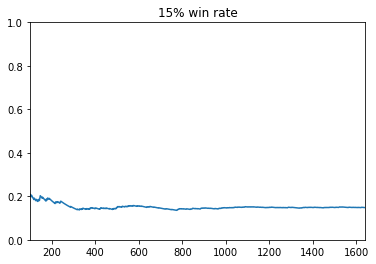

In [849]:
df['ones'] = np.ones(len(df))
df['win_rate'] = df.success.cumsum() / df.ones.cumsum()
win_title = '{:.0f}% win rate'.format(df.win_rate.iloc[-1] * 100)
df.win_rate.plot(title=win_title, xlim=(100), ylim=(0, 1))

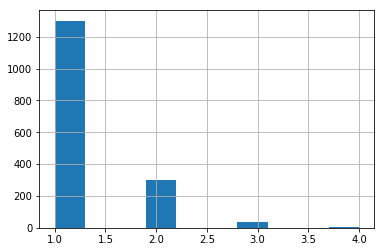

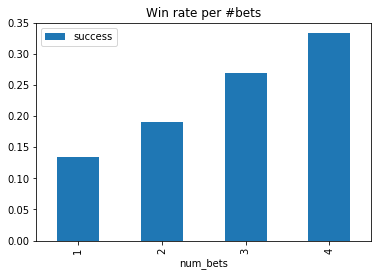

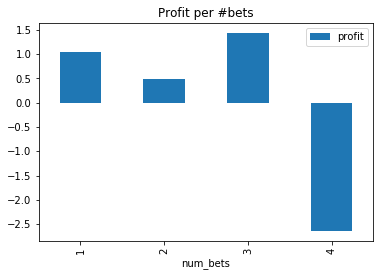

In [850]:
# profit per num bets 
df.num_bets.hist()
groups = df.groupby('num_bets').mean()
groups.plot(kind='bar', y='success', title='Win rate per #bets')
groups.plot(kind='bar', y='profit', title='Profit per #bets')

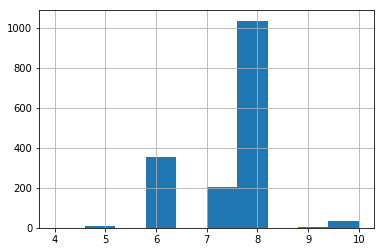

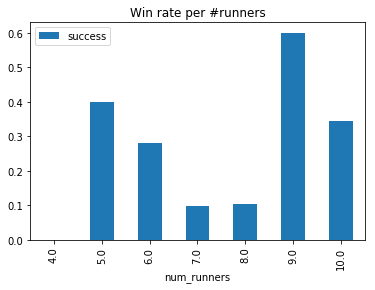

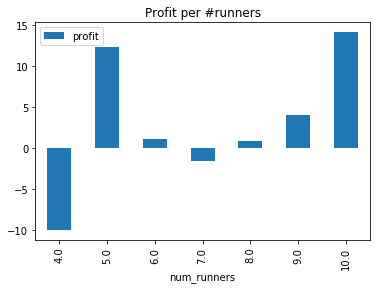

In [851]:
# profit per num runners
df.num_runners.hist()
groups = df.groupby('num_runners').mean()
groups.plot(kind='bar', y='success', title='Win rate per #runners')
groups.plot(kind='bar', y='profit', title='Profit per #runners')

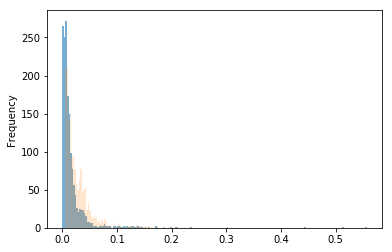

In [852]:
# max diff
df.win_diff.plot(kind='hist', bins=200, alpha=0.6)
df.max_diff.plot(kind='hist', bins=200, alpha=0.2)

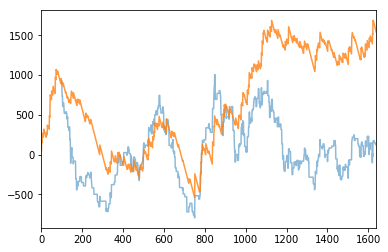

In [853]:
# df.profit.plot(kind='hist', bins=50, xlim=(-5), ylim=(0, 140))
df.profit.rolling(100).sum().plot(alpha=0.5)
df.profit.cumsum().plot(alpha=0.8)

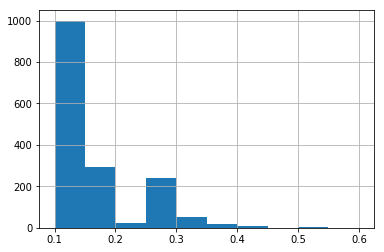

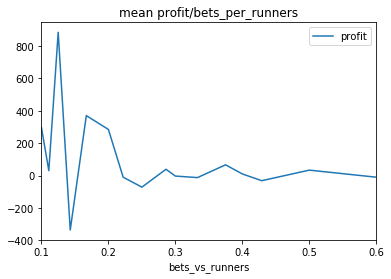

In [854]:
# bets/runners
df['bets_vs_runners'] = df.num_bets / df.num_runners
df['bets_vs_runners'].hist(bins=10)
groups = df.groupby(df['bets_vs_runners'].apply(lambda x: round(x, 3))).sum()
groups.plot(kind='line', y='profit', title='mean profit/bets_per_runners')

In [855]:
# # pred vs scale
# df['prob_vs_scale'] = df.pr / df.num_runners
# df['bets_vs_runners'].hist(bins=10)
# groups = df.groupby(df['bets_vs_runners'].apply(lambda x: round(x, 3))).sum()
# groups.plot(kind='line', y='profit', title='mean profit/bets_per_runners')

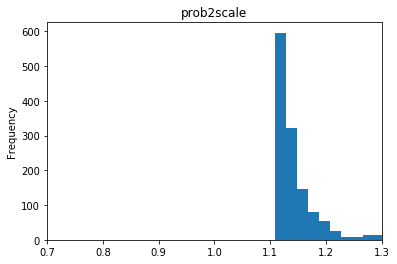

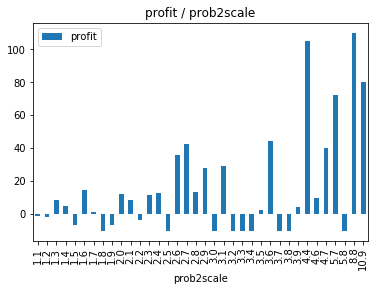

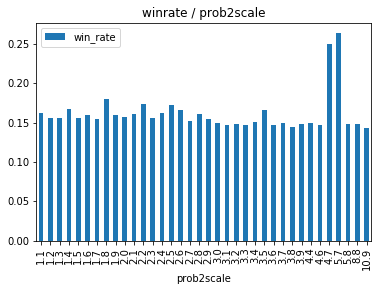

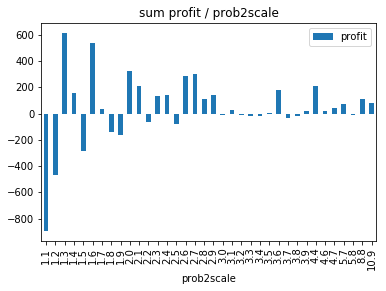

In [856]:
df.prob2scale.plot(kind='hist', bins=500, xlim=(.7, 1.3), title='prob2scale')
groups = df.groupby(df['prob2scale'].apply(lambda x: round(x, 1))).mean()
groups.plot(kind='bar', y='profit', title='profit / prob2scale')
groups.plot(kind='bar', y='win_rate', title='winrate / prob2scale')

groups_sum = df.groupby(df['prob2scale'].apply(lambda x: round(x, 1))).sum()
groups_sum.plot(kind='bar', y='profit', title='sum profit / prob2scale')